Credit_Limit_Analysis_Plan.ipynb

Automatically generated by Colab.

# Kế hoạch Phân tích Dữ liệu: Xây dựng Mô hình Hồi quy Tuyến tính Dự báo Hạn mức Tín dụng

## 1. Cài đặt và Nhập Thư viện


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Đã nhập xong các thư viện cần thiết.")


Đã nhập xong các thư viện cần thiết.


## 2. Mô tả và Chuẩn bị Dữ liệu (Data Simulation & Preparation)

### 2.1 & 2.2 Tạo Dữ liệu Giả lập
Tạo 300 quan sát dựa trên phương trình tuyến tính ngầm định (Ground Truth).


In [7]:
# Thiết lập hạt giống ngẫu nhiên để tái lập kết quả
np.random.seed(42)
n = 300

# --- Biến độc lập (X) ---
# Monthly_Income: Trung bình 5500, độ lệch 2000
income = np.random.normal(5500, 2000, n).clip(1500, 20000)

# Credit_Score: Trung bình 700, độ lệch 50
credit_score = np.random.normal(700, 50, n).clip(300, 850)

# Is_Homeowner: 0 hoặc 1
is_homeowner = np.random.choice([0, 1], n)

# Education_Level: 4 cấp độ
edu_levels = ['High School', 'Undergraduate', 'Graduate', 'Professional']
education = np.random.choice(edu_levels, n, p=[0.25, 0.4, 0.25, 0.1])

# Tạo DataFrame
df = pd.DataFrame({
    'Monthly_Income': income,
    'Credit_Score': credit_score,
    'Is_Homeowner': is_homeowner,
    'Education_Level': education
})

# --- Xử lý biến (Feature Engineering) ---
# 1. Dummy Variables: Chuyển Education thành số, drop_first=True (High School là tham chiếu)
# FIX 1: Định nghĩa thứ tự Category để đảm bảo 'High School' đứng đầu
df['Education_Level'] = pd.Categorical(df['Education_Level'], 
                                       categories=['High School', 'Undergraduate', 'Graduate', 'Professional'], 
                                       ordered=True)

# FIX 2: Thêm dtype=int để đảm bảo output là 0/1 (int) thay vì True/False (bool) gây lỗi statsmodels
df_dummies = pd.get_dummies(df['Education_Level'], prefix='Edu', drop_first=True, dtype=int)

# 2. Tạo Biến Phụ Thuộc (Y) - Credit_Limit
noise = np.random.normal(0, 800, n) # Nhiễu ngẫu nhiên

# Công thức: Y = -20000 + 1.8*Income + 30*Score + 3000*Home + Dummies + Noise
y = (
    -20000 +
    (df['Monthly_Income'] * 1.8) +
    (df['Credit_Score'] * 30) +
    (df['Is_Homeowner'] * 3000) +
    (df_dummies.get('Edu_Undergraduate', 0) * 1500) +
    (df_dummies.get('Edu_Graduate', 0) * 4000) +
    (df_dummies.get('Edu_Professional', 0) * 8000) +
    noise
)

df['Credit_Limit'] = y.round(2)

# Gộp dummies vào DF chính
df_final = pd.concat([df, df_dummies], axis=1)

print("--- 5 Dòng đầu tiên của dữ liệu giả lập ---")
print(df_final.head())


--- 5 Dòng đầu tiên của dữ liệu giả lập ---
   Monthly_Income  Credit_Score  Is_Homeowner Education_Level  Credit_Limit  Edu_Undergraduate  Edu_Graduate  Edu_Professional
0     6493.428306    658.550249             0   Undergraduate      11724.26                  1             0                 0
1     5223.471398    671.990948             1   Undergraduate      13508.45                  1             0                 0
2     6795.377076    737.364680             1   Undergraduate      18816.15                  1             0                 0
3     8546.059713    730.518513             0   Undergraduate      18993.13                  1             0                 0
4     5031.693251    698.954920             1     High School      12832.71                  0             0                 0


## 3. Phân tích Các Yếu tố Ảnh hưởng và Trực quan hóa Dữ liệu

### 3.1 Các Yếu tố Ảnh hưởng đến Hồi quy Tuyến tính
Trong Linear Regression, kết quả mô hình có thể bị ảnh hưởng lớn bởi các đặc điểm sau của dữ liệu:
1. **Mối quan hệ Tuyến tính (Linearity)**: Giả định quan trọng nhất. Nếu dữ liệu thực tế cong (phi tuyến), đường thẳng hồi quy sẽ không khớp tốt.
2. **Ngoại lai (Outliers)**: Các điểm dữ liệu bất thường có thể kéo lệch đường hồi quy, làm sai lệch hệ số ước lượng.
3. **Đa cộng tuyến (Multicollinearity)**: Nếu các biến đầu vào (ví dụ: Income và Credit Score) tương quan quá mạnh với nhau, mô hình sẽ gặp khó khăn trong việc xác định đóng góp riêng của từng biến, làm phương sai của hệ số tăng cao.
4. **Phân phối của biến (Distribution)**: Mặc dù không bắt buộc biến độc lập phải chuẩn, nhưng nếu biến phụ thuộc (`Credit_Limit`) bị lệch (skewed) quá nhiều, có thể cần biến đổi (log transformation) để cải thiện hiệu suất.
5. **Phương sai đồng nhất (Homoscedasticity)**: Sai số dự báo nên ổn định, không thay đổi theo giá trị của biến dự báo.

### 3.2 Trực quan hóa Dữ liệu
Đoạn code dưới đây sẽ giúp chúng ta kiểm tra hình dạng dữ liệu và các mối quan hệ này.

/tmp/ipykernel_9278/2196532765.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Education_Level', y='Credit_Limit', data=df_final, palette='Set2')


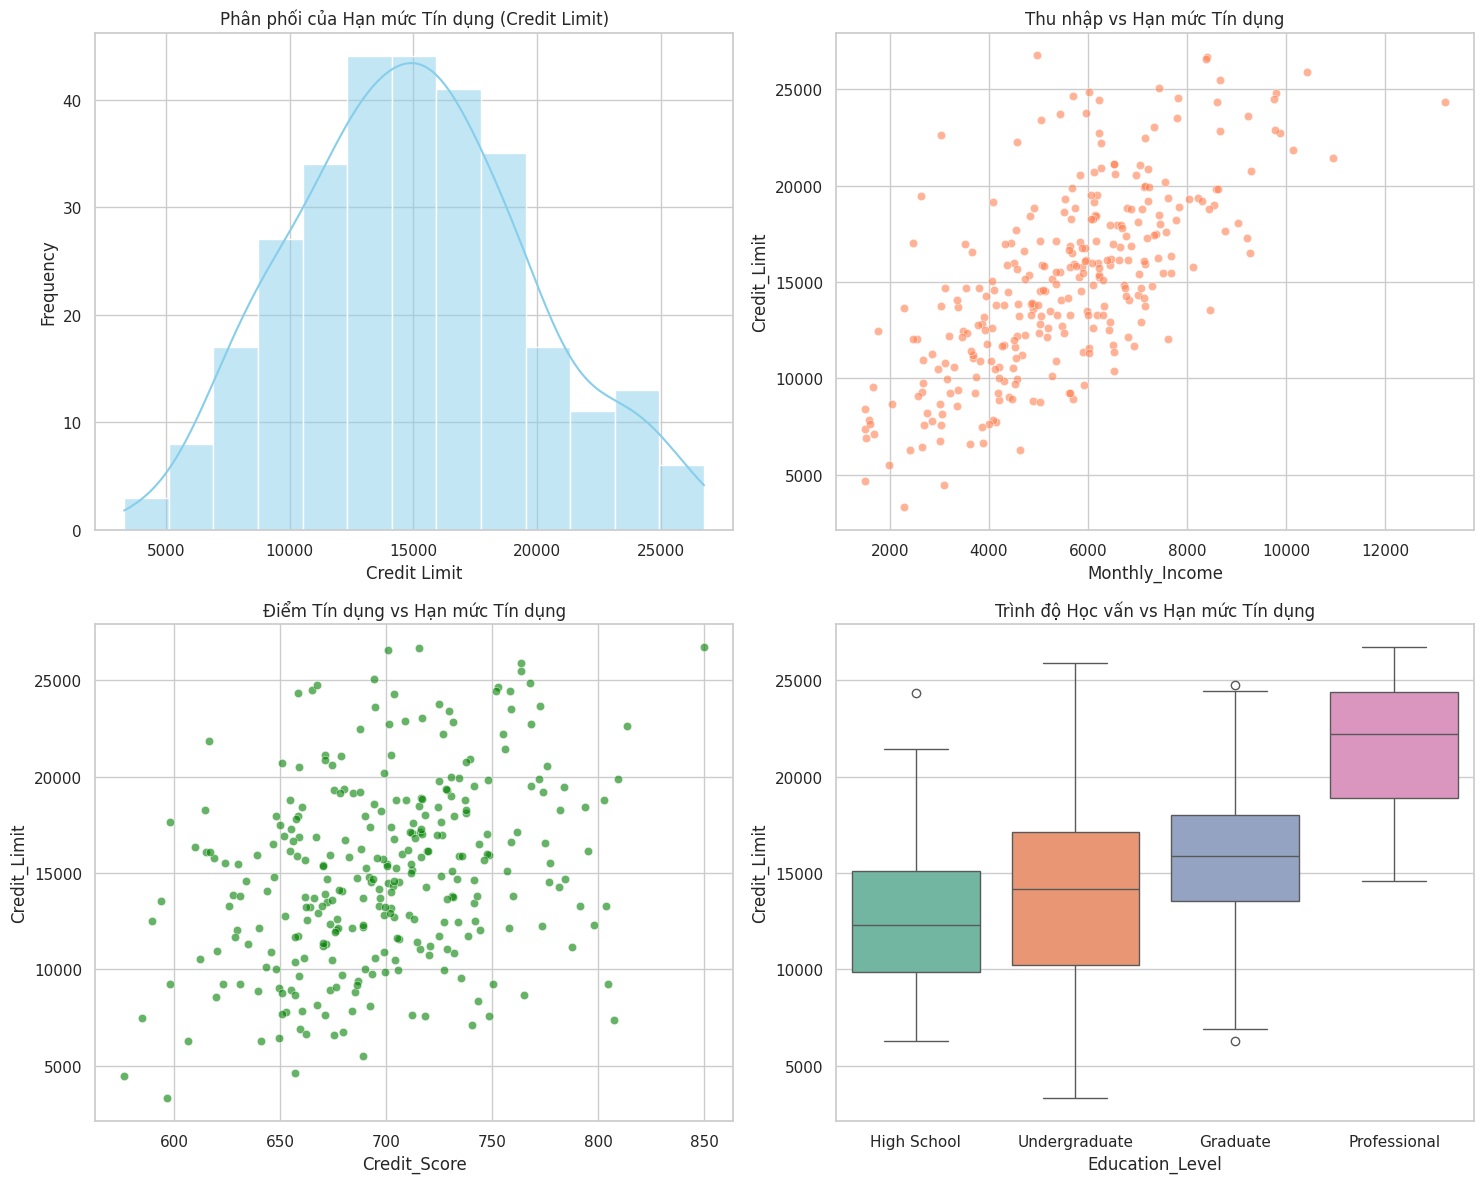

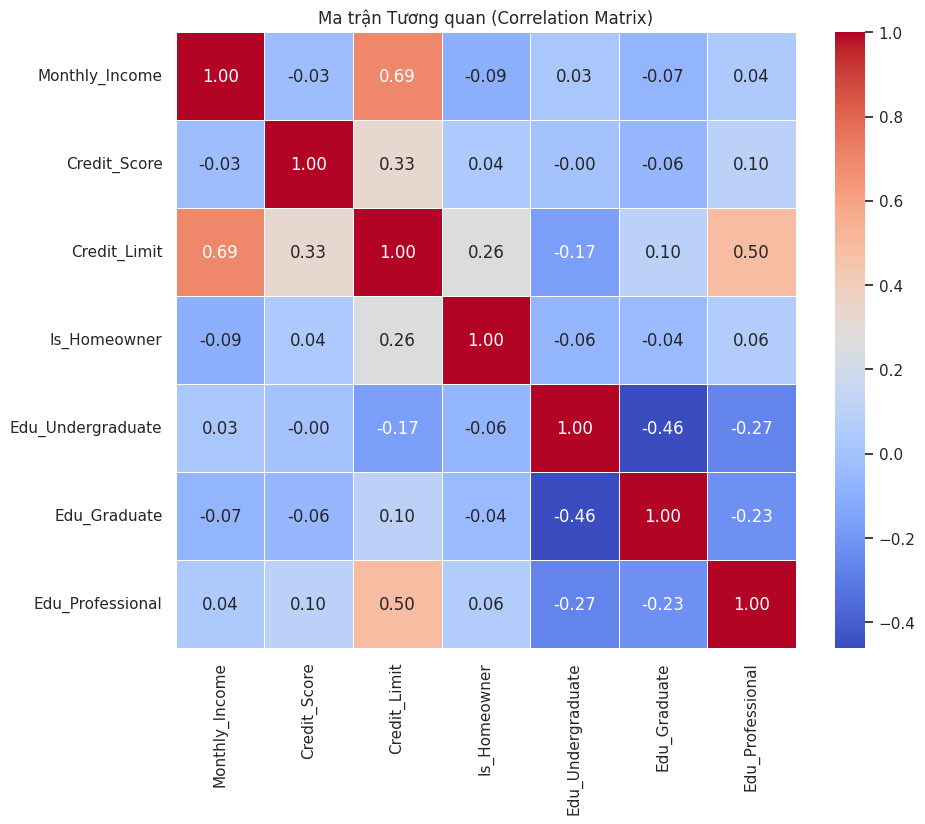

In [8]:
# Thiết lập kích thước đồ thị lớn hơn chút để dễ nhìn
plt.figure(figsize=(15, 12))

# 1. Phân phối của biến mục tiêu (Target Variable Distribution)
plt.subplot(2, 2, 1)
sns.histplot(df_final['Credit_Limit'], kde=True, color='skyblue')
plt.title('Phân phối của Hạn mức Tín dụng (Credit Limit)')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')

# 2. Mối quan hệ giữa Thu nhập và Hạn mức (Linearity Check)
plt.subplot(2, 2, 2)
sns.scatterplot(x='Monthly_Income', y='Credit_Limit', data=df_final, color='coral', alpha=0.6)
plt.title('Thu nhập vs Hạn mức Tín dụng')

# 3. Mối quan hệ giữa Điểm tín dụng và Hạn mức (Linearity Check)
plt.subplot(2, 2, 3)
sns.scatterplot(x='Credit_Score', y='Credit_Limit', data=df_final, color='green', alpha=0.6)
plt.title('Điểm Tín dụng vs Hạn mức Tín dụng')

# 4. Boxplot cho biến Phân loại: Education vs Credit Limit
plt.subplot(2, 2, 4)
sns.boxplot(x='Education_Level', y='Credit_Limit', data=df_final, palette='Set2')
plt.title('Trình độ Học vấn vs Hạn mức Tín dụng')

plt.tight_layout()
plt.show()

# 5. Kiểm tra Đa cộng tuyến qua Heatmap (Correlation Matrix)
plt.figure(figsize=(10, 8))
# Chỉ lấy các cột số để tính correlation
numeric_cols = ['Monthly_Income', 'Credit_Score', 'Credit_Limit', 'Is_Homeowner'] + list(df_dummies.columns)
corr_matrix = df_final[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Ma trận Tương quan (Correlation Matrix)')
plt.show()

### 3.3 Đánh giá Sơ bộ từ Biểu đồ
- **Phân phối Credit Limit**: Xem biểu đồ histogram đầu tiên. Nếu nó có hình chuông (bell curve), đó là dấu hiệu tốt. Nếu bị lệch trái hoặc phải quá nhiều, có thể cần xử lý.
- **Tuyến tính**: Quan sát biểu đồ tán xạ (Income vs Limit, Score vs Limit). Nếu các điểm phân bố gọn quanh một đường thẳng chéo lên, giả định tuyến tính được thỏa mãn. Nếu thấy đường cong, mô hình tuyến tính đơn giản có thể không đủ tốt.
- **Tương quan (Heatmap)**: 
    - Các biến độc lập (Income, Score) nên có tương quan cao với biến mục tiêu (Credit Limit) -> Dấu hiệu dự báo tốt.
    - Giữa các biến độc lập với nhau không nên có tương quan quá cao (ví dụ > 0.8). Nếu có, đó là dấu hiệu của đa cộng tuyến.